# Benchmark Analysis

In [1]:
import sys  
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from typing import List

%matplotlib inline

In [3]:
root_dir = '/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1'

## Utils 

In [4]:
def get_path(*entries):
    return os.path.join(*entries)    


In [5]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [6]:
def extraction_pandas_frame_algo(path):
    df = pd.read_csv(path)
    
    # dropping columns we do not care about
    df = df.drop(['iterations','bytes_per_second','items_per_second','label','error_occurred','error_message'],axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean','median','stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/')+1:x[0].rfind('_')],axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'],ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C']*3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C']*3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C','median_id','stddev_id'],axis=1)
    results_gcc['Compiler'] = 'TODO'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']),"").replace('/_mean',''),axis=1)

    return results_gcc


## Cleaning input files
The benchmark csv's are not parseable csv's because they have a header that is not valid csv. We first need to strip this away.

In [7]:
def clean_file_content(input_filename,output_filename):
    with open(input_filename, 'r+') as fr: 
            lines = fr.readlines()
    
    with open(output_filename, 'w+') as fw: 
            reached = False

            for line in lines:
                if line.startswith('name,iterations,real_time'):
                    reached = True

                if reached:
                    fw.write(line)

def clean_all_files(target_dir,target_prefix="cleaned"):
    for dirpath, dirnames, filenames in os.walk(target_dir):
        if not dirnames:
            print(dirpath, "has ", len(filenames), "files")
            final_files = [(os.path.join(dirpath,x),os.path.join(dirpath,target_prefix,x)) for x in filenames]

            for input_filename, output_filename in final_files:
                ensure_file_existence(output_filename)
                clean_file_content(input_filename,output_filename)    
    print("Done!")


In [8]:
clean_all_files("/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1")
# in this case the location of the cleaned files will be /[DEFAULT|NUMACTL]/cleaned

/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1/NVHPC_Multicore/DEFAULT/cleaned/cleaned/cleaned has  65 files
/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1/GCC_TBB/DEFAULT/cleaned/cleaned/cleaned has  66 files
Done!


## B1_1 - Linear GCC VS NVHC (Multicore)
First we take a look at the speedup compared 

<Axes: xlabel='n'>

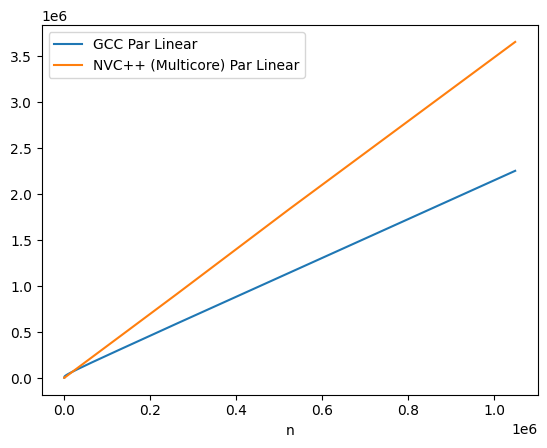

In [9]:
fig, ax = plt.subplots()

b1_1_gcc_par = extraction_pandas_frame_algo(root_dir+'/GCC_TBB/DEFAULT/cleaned/b1_1_for_each_linear_par_Default.csv')
b1_1_gcc_par.plot(x='n',y='real_time',ax=ax,label='GCC Par Linear')

b1_1_nvc_par = extraction_pandas_frame_algo(root_dir+'/NVHPC_Multicore/DEFAULT/cleaned/b1_1_for_each_linear_par_Default.csv')
b1_1_nvc_par.plot(x='n',y='real_time',ax=ax,label='NVC++ (Multicore) Par Linear')

